In [1]:
import mdtraj as md
import pyemma as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional, Union, Tuple
from pathlib import Path
import pickle
from scipy.stats import entropy
import seaborn as sns

from msmtools.estimation import transition_matrix as _transition_matrix
from msmtools.analysis import timescales as _timescales

In [2]:
def featurizer(hp_dict: Dict, traj_paths: List[str], top_path: str) -> List[np.ndarray]:
    if hp_dict['feature__value'] == 'dihedrals':
        assert hp_dict['dihedrals__which'] == 'all'
        def f(traj: md.Trajectory, **kwargs) -> np.ndarray:
            _, phi = md.compute_phi(traj)
            _, psi = md.compute_psi(traj)
            _, chi1 = md.compute_chi1(traj)
            _, chi2 = md.compute_chi2(traj)
            _, chi3 = md.compute_chi3(traj)
            _, chi4 = md.compute_chi4(traj)
            _, chi5 = md.compute_chi5(traj)
            ftraj = np.concatenate([phi, psi, chi1, chi2, chi3, chi4, chi5], axis=1)
            ftraj = np.concatenate([np.cos(ftraj), np.sin(ftraj)], axis=1)
            return ftraj

    elif hp_dict['feature__value'] == 'distances':
        def f(traj: md.Trajectory, **kwargs):
            scheme = kwargs['distances__scheme']
            transform = kwargs['distances__transform']
            centre = kwargs['distances__centre']
            steepness = kwargs['distances__steepness']
            ftraj, _ = md.compute_contacts(traj, scheme=scheme)
            if transform=='logistic':
                ftraj = 1.0/(1+np.exp(-steepness*(ftraj - centre)))
            return ftraj
    else:
        raise ValueError
    ftrajs = []
    for traj_path in traj_paths:
        traj = md.load(traj_path, top=top_path)
        ftrajs.append(f(traj, **hp_dict))
    return ftrajs


def tica(hp_dict: Dict[str, Union[float, int, str]], ftrajs: List[np.ndarray]) -> List[np.ndarray]:
    lag = hp_dict['tica__lag']
    stride = hp_dict['tica__stride']
    dim = hp_dict['tica__dim']
    tica = pm.coordinates.tica(ftrajs, lag=lag, dim=dim, kinetic_map=True)
    ttrajs = tica.get_output()
    return ttrajs, tica

def kmeans(hp_dict: Dict, ttrajs: List[np.ndarray], seed: int) -> List[np.ndarray]:
    k = hp_dict['cluster__k']
    max_iter = hp_dict['cluster__max_iter']
    stride = hp_dict['cluster__stride']
    kmeans = pm.coordinates.cluster_kmeans(ttrajs, k=k, max_iter=max_iter, stride=stride, fixed_seed=seed, n_jobs=1)
    dtrajs = kmeans.dtrajs
    return dtrajs, kmeans


def its(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    its_obj = pm.msm.timescales_msm(dtrajs=dtrajs, lags=lags, nits=nits)
    return its_obj.timescales


def score(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    all_vs = []
    for lag in lags: 
        m = pm.msm.estimate_markov_model(dtrajs, lag=lag)
        vs = np.array([m.score(dtrajs, score_k=k) for k in range(2, nits+2)])
        vs = vs.reshape(1, -1)
        all_vs.append(vs)
    all_vs = np.concatenate(all_vs, axis=0)
    return all_vs
        


def bootstrap(ftrajs: List[np.ndarray], rng: np.random.Generator) -> np.ndarray:
    probs = np.array([x.shape[0] for x in ftrajs])
    probs = probs/np.sum(probs)
    ix = np.arange(len(ftrajs))
    new_ix = rng.choice(ix,size=len(ftrajs), p=probs, replace=True)
    return new_ix



def summarise(df):
    df_summary = df.groupby(['hp_ix', 'lag', 'process']).agg(median=(0, lambda x: np.quantile(x, 0.5)),
                                                                   lb=(0, lambda x: np.quantile(x, 0.025)),
                                                                   ub=(0, lambda x: np.quantile(x, 0.975)), 
                                                                   count =(0, lambda x: x.shape[0]-x.isna().sum()))
    return df_summary


def samples_to_summary(samples: np.ndarray, lags: List[int],  hp_ix: int)-> pd.DataFrame: 
    """
    samples=np.ndarray[lagtime, process, bs_sample]
    """
    df = pd.concat({(hp_ix, lags[i], j+2): pd.DataFrame(samples[i, j, :]) for i in range(samples.shape[0]) for j in range(samples.shape[1])})
    df.index.rename(('hp_ix', 'lag', 'process', 'bs_ix'), inplace=True)
    df_summary = summarise(df)
    return df_summary


def get_all_projections(msm: pm.msm.MaximumLikelihoodMSM, num_procs: int, dtrajs: List[np.ndarray]) -> List[np.ndarray]:
    """ Project dtrajs onto first num_proc eigenvectors excluding stationary distribution. i.e., if num_proc=1 then project onto the slowest eigenvector only. 
    All projections ignore the stationary distribution
    """
    evs = msm.eigenvectors_right(num_procs+1)
    active_set = msm.active_set
    NON_ACTIVE_PROJ_VAL = np.nan # if the state is not in the active set, set the projection to this value. 
    NON_ACTIVE_IX_VAL = -1
    evs = evs[:, 1:] # remove the stationary distribution
    proj_trajs = []
    for dtraj in dtrajs:
        all_procs = []
        for proc_num in range(num_procs):

            tmp = np.ones(dtraj.shape[0], dtype=float)
            tmp[:] = NON_ACTIVE_PROJ_VAL

            for i in range(dtraj.shape[0]):
                x = msm._full2active[dtraj[i]]
                if x != NON_ACTIVE_IX_VAL:
                    tmp[i] = evs[x, proc_num]
                tmp = tmp.reshape(-1, 1)

            all_procs.append(tmp)
        all_procs = np.concatenate(all_procs, axis=1)
        proj_trajs.append(all_procs)

    return proj_trajs

In [3]:
protein = '1fme'
hp_ix = 53
n_procs = 2
lag = 41

seed = 49587
rng = np.random.default_rng(seed)
n_bootstraps = 100
nits=25

hps = pd.read_hdf('../data/msms/hpsample.h5')
top_path = f'/Users/robertarbon/Data/DESRES/DESRES-Trajectory_{protein.upper()}-0-protein/{protein.upper()}-0-protein/protein.pdb'
traj_paths = list(Path('/Users/robertarbon/Data/DESRES').rglob(f'*{protein.upper()}*/**/*.xtc'))
traj_paths = [str(x) for x in traj_paths]
traj_paths.sort()
assert traj_paths

In [4]:

ftrajs_all = featurizer(hps.iloc[hp_ix, :].to_dict(), traj_paths, top_path)

# for i in range(n_bootstraps):
#     print(i, end=', ')
bs_ix = bootstrap(ftrajs_all, rng)
bs_traj_paths = [traj_paths[i] for i in bs_ix]
ftrajs = [ftrajs_all[i] for i in bs_ix]


assert len(ftrajs) == len(ftrajs_all)
ttrajs, tica_mod = tica(hps.iloc[hp_ix, :].to_dict(), ftrajs)
dtrajs, kmeans_mod = kmeans(hps.iloc[hp_ix, :].to_dict(), ttrajs, seed)
mod = pm.msm.estimate_markov_model(dtrajs, lag=lag)
ptrajs = get_all_projections(mod, n_procs, dtrajs)

calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

In [5]:
index = pd.MultiIndex.from_tuples([(bs_traj_paths[i], j) for i in range(len(traj_paths)) for j in range(ptrajs[i].shape[0])])

In [6]:
ptrajs_all = np.concatenate(ptrajs, axis=0)
ptrajs_df = pd.DataFrame(ptrajs_all, index=index, columns=[f"{i+2}" for i in range(n_procs)])

In [7]:
def mixing_ent(x): 
    x = np.abs(x)
    return entropy(x)

ptrajs_df['mixing'] = ptrajs_df.apply(mixing_ent, axis=1)
ptrajs_df.dropna(inplace=True)

In [8]:
ptrajs_df.head()

2         3  \
/Users/robertarbon/Data/DESRES/DESRES-Trajector... 0    -0.555786 -0.475742   
                                                   1    -0.555786 -0.475742   
                                                   2    -0.555786 -0.475742   
                                                   3    -0.555786 -0.475742   
                                                   4    -0.555786 -0.475742   
...                                                           ...       ...   
/Users/robertarbon/Data/DESRES/DESRES-Trajector... 1995  0.655816 -0.099941   
                                                   1996  1.439954  0.206176   
                                                   1997  0.655816 -0.099941   
                                                   1998  0.655816 -0.099941   
                                                   1999  1.439954  0.206176   

                                                           mixing  
/Users/robertarbon/Data/DESRES/DESRES-Trajector... 0     0.690133  
                                                   1     0.690133  
                                                   2     0.690133  
                                                   3     0.690133  
                                                   4     0.690133  
...                                                           ...  
/Users/robertarbon/Data/DESRES/DESRES-Trajector... 1995  0.390621  
                                                   1996  0.377254  
                                                   1997  0.390621  
                                                   1998  0.390621  
                                                   1999  0.377254  

[328000 rows x 3 columns]

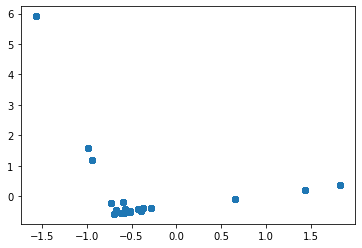

In [13]:
plt.scatter(ptrajs_df.iloc[::1, 0].values, 
            ptrajs_df.iloc[::1, 1].values, label='ev 2')


In [15]:
n_ev = "2"
n_cuts = 50
threshold = 1e-6

df = ptrajs_df.loc[:, [n_ev, 'mixing']].copy(deep=True)
df['cat'] = pd.qcut(df[n_ev], q=50, duplicates='drop')
df['min'] = df.groupby('cat')['mixing'].transform('min')
df2 = df.loc[np.abs(df['mixing']- df['min'])< threshold, :]
sample = df2.groupby('cat').sample(n=1)
sample.sort_values(by='cat', inplace=True)
# sample_ixs = list(sample.index)
# traj = md.join([md.load_frame(x, top=top_path, index=y) for x, y in sample_ixs])